# ***Projekt zaliczeniowy - opis obrazu - Śledzenie gry w bilard (snooker)***

### Autorzy

  Ewa Komkowska (136737)

  Aleksander Iżemski (150659)

  Emilia Maciejewska (136764)

## Funkcje pomocnicze i importy

In [ ]:
import cv2
from ipywidgets import Video
import numpy as np 
import PIL
import random
try:
    import Image
except ImportError:
    from PIL import Image

In [ ]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Zbiór danych 



Zbiór danych został przygotowany w oparciu o film znaleziony na platformie YouTube, jednak w celu ułatwienia pobierania został on umieszczony na dysku Google. 

### Pobieranie 

In [ ]:
!gdown --id 1DX6EdTPPrhjpc_NkJfn7jocp0WzjeH5y # snooker.mp4
!gdown --id 1rIc8o50dcDgIy00sEsqiGGTbjWkPKoHJ # poczatek

Downloading...
From: https://drive.google.com/uc?id=1DX6EdTPPrhjpc_NkJfn7jocp0WzjeH5y
To: /content/snooker.mp4
9.33MB [00:00, 10.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rIc8o50dcDgIy00sEsqiGGTbjWkPKoHJ
To: /content/snooker_start.png
100% 909k/909k [00:00<00:00, 60.5MB/s]


## Wykrywanie bil

### Wyświetlenie plików

W tej części zadania wykorzystaliśmy metody zawarte w bibliotece OpenCV, takie jak: VideoCapture(), from_file() czy isOpened(). 

In [ ]:
def read_videos(video_path):
  snooker = cv2.VideoCapture(video_path)
  if not snooker.isOpened():
      return

  snooker_width = int(snooker.get(3))
  snooker_height = int(snooker.get(4))

  snooker_fps = snooker.get(cv2.CAP_PROP_FPS)
  
  Video.from_file(video_path)

  return snooker, snooker_width, snooker_height, snooker_fps

### Wykrywanie położenia na podstawie pierwszej klatki z filmu

Aby poprawnie określić położenie wszystkich bil na początkowej klatce filmu wykorzystaliśmy statyczny jej obraz w postaci zdjęcia. Wykonaliśmy operacje morfologiczne związane z thresholdem - jeśli dany piksel miał wartości większe od określonego progu, zmienialiśmy jego kolor na czarny, aby zwiększyć kontrast barw. Kolejnym krokiem było złagodzenie krawędzi, do których wykorzystaliśmy funkcję filter2D. Na koniec przekonwertowaliśmy obraz do przestrzeni szarości i wykonaliśmy tranformatę Hough w celu odnalezienia okręgów. 

In [ ]:
def read_start_image(image_path, param1, param2, minRadius, maxRadius):
  snooker_start = cv2.imread(image_path, cv2.IMREAD_COLOR)

  snooker_start[snooker_start[:,:,0] >= 200] = 0

  kernel = np.ones((3,3),np.float32)/9
  snooker_start = cv2.filter2D(snooker_start,-1,kernel)
  # imshow(snooker_start)

  snooker_start_gray = cv2.cvtColor(snooker_start, cv2.COLOR_BGR2GRAY)
  
  # imshow(snooker_start_gray)

  circles = cv2.HoughCircles(snooker_start_gray, cv2.HOUGH_GRADIENT, 1, 20, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
  circles = np.uint16(np.around(circles))
  print('Znalezionych okręgów:', len(circles[0]))

  # Wydzielenie łuz jako osobna tablica 
  pocket_bbox = sorted(circles[0, :, 1])[0:3]
  print('Pockets: ', pocket_bbox)

  for i in circles[0, :]:
    if i[1] not in pocket_bbox:
      cv2.circle(snooker_start,(i[0],i[1]),i[2],(0,255,0),2)
      cv2.circle(snooker_start,(i[0],i[1]),2,(0,0,255),3)

  imshow(snooker_start)

  return pocket_bbox, circles

### Wpadnięcie kuli do łuzy i zderzenie kul 

Aby wykryć wpadnięcie kuli do łuzy i zderzenie dwóch kul wykorzystaliśmy trackery bil i sprawdzaliśmy, czy nakładają się one na siebie. Dodatkowo uwzględnialiśmy określony błąd obliczeniowy, ponieważ czasem mogło nastąpić minimalne przesunięcie punktów należących do trackera. 
Zdarzenie związane ze zderzeniem się dwóch kul oznaczyliśmy białym prostokątem.

In [ ]:
def check_if_overlap(a,b,error=2,frame=None,update_frame=False):
    l1 = (int(a[0])-error, int(a[1])-error)
    r1 = (int(a[0] + a[2])+error, int(a[1] + a[3])+error)
    l2 = (int(b[0])-error, int(b[1])-error)
    r2 = (int(b[0] + b[2])+error, int(b[1] + b[3])+error)

    if (l1[0] > r2[0] or l2[0] > r1[0]):
        return False
    
    if (l1[1] > r2[1] or l2[1] > r1[1]):
        return False
    
    if update_frame:
        cv2.rectangle(frame, l1, r2, (255, 255, 255),-1)
    return True


def check_if_balls_hit(circles,frame):
    for i in range(len(circles)):
        for j in range(i+1,len(circles)):
            check_if_overlap(circles[i],circles[j],frame=frame,update_frame=True)
                
def check_if_balls_score(cirsles,pockets,circles_tracker):
  new_trackers = []
  for i in range(len(circles_tracker)):
    for pocket in pockets:
      if not check_if_overlap(cirsles[i],pocket):
        if circles_tracker[i] not in new_trackers:
          new_trackers.append(circles_tracker[i])
          
  return new_trackers 

### Śledzenie na podstawie ustalonych położeń

Podczas śledzenia bil wykorzystaliśmy TrackerCSRT z biblioteki OpenCV. Punkty początkowe wykryliśmy w poprzedniej części na podstawie pierwszej klatki z filmu. Dodatkowo przy inicjalizacji pominęliśmy punkty wykrywające łuzy (zapamiętaliśmy jedynie ich położenie), a każda bila ma losowany własny kolor obramowania. Dodatkowo sprawdzamy także, czy dana bila wpadła do łuzy.

In [ ]:
def draw_bbox(frame, bbox, color=(255, 255, 255)):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  cv2.rectangle(frame, p1, p2, color, 2, 1)

In [ ]:
def ball_tracking(snooker, circles, file_name, snooker_fps, snooker_width, snooker_height, pocket_bbox):
  snooker.set(cv2.CAP_PROP_POS_FRAMES, 0)
  ret, frame = snooker.read()

  circles_bbox = []
  circles_tracker = []
  circle_colours = []
  pocket_bbox_position = []

  for circle in circles[0, :]:
    if circle[1] not in pocket_bbox:
      circles_bbox.append((circle[0] - circle[2], circle[1] - circle[2], 3 * circle[2], 3 * circle[2]))
      tracker = cv2.TrackerCSRT_create()
      circles_tracker.append(tracker)
      circle_colours.append((random.randint(0,256), random.randint(0,256), random.randint(0,256)))
      
      if not tracker.init(frame, circles_bbox[-1]):
        print('Algorytm śledządzy bilę nie zainicjalizowany w punkcie:', circles_bbox[-1])
      
    else:
      pocket_bbox_position.append((circle[0] - circle[2], circle[1] - circle[2], 3 * circle[2], 3 * circle[2]))

  snooker_track = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'DIVX'), snooker_fps, (snooker_width, snooker_height))

  snooker.set(cv2.CAP_PROP_POS_FRAMES, 0)
  while snooker.isOpened():
      ret, frame = snooker.read()

      if ret:
        for i, tracker in enumerate(circles_tracker): 
          ok, circles_bbox[i] = tracker.update(frame)
          if ok: 
            draw_bbox(frame, circles_bbox[i], circle_colours[i])
        
        check_if_balls_hit(circles_bbox,frame)
        circles_tracker=check_if_balls_score(circles_bbox,pocket_bbox_position,circles_tracker)
        draw_bbox(frame,pocket_bbox_position[0],(255,0,0))
        draw_bbox(frame,pocket_bbox_position[1],(255,0,0))
        draw_bbox(frame,pocket_bbox_position[2],(255,0,0))
        snooker_track.write(frame)
        
      else:
          break

  snooker_track.release()

## Główny algorytm

Funkcja została stworzona w celu łatwiejszego uruchomienia całego algorytmu - wykonuje po kolei opisane powyżej kroki tak, aby użytkownik nie musiał martwić się o kolejność wywoływania poszczególnych funkcji.

In [ ]:
def main_algorithm(video_path, image_path, param1, param2, minRadius, maxRadius, output_path):
  snooker, snooker_width, snooker_height, snooker_fps = read_videos(video_path)
  pocket_bbox, circles = read_start_image(image_path, param1, param2, minRadius, maxRadius)
  ball_tracking(snooker, circles, output_path, snooker_fps, snooker_width, snooker_height, pocket_bbox)

## Przykłady uruchomienia algorytmu

Poniżej zaprezentowano przykład uruchomienia algorytmu na pobranym w pierwszej części zbiorze testowym. 

### Wywołanie

Znalezionych okręgów: 14
Pockets:  [82, 84, 88]


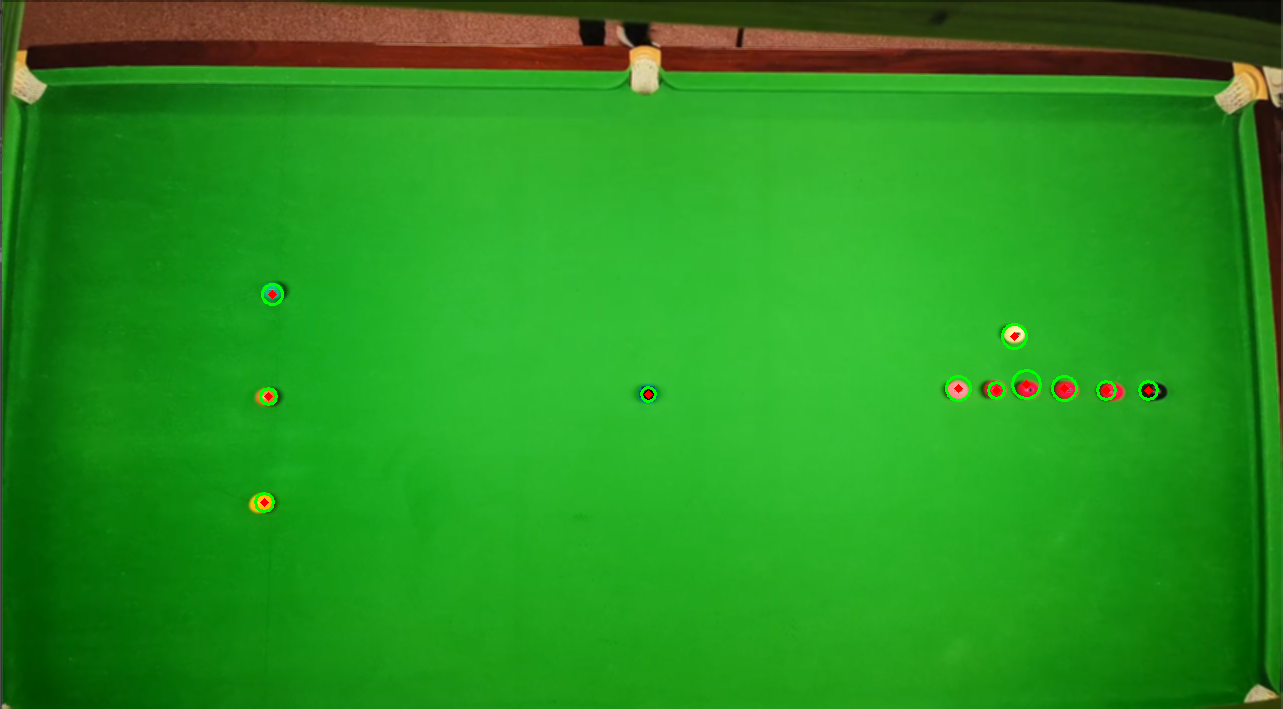

In [ ]:
main_algorithm('./snooker.mp4', './snooker_start.png', 200, 12, 7, 19, './snooker.avi')
# read_start_image('./snooker_start.png', 200, 15, 7, 20) # stare parametry, nowe: 200, 12, 7, 19

### Wyświetlenie rezultatu

In [ ]:
!ffmpeg -hide_banner -loglevel error -i snooker.avi -y snooker.mp4
Video.from_file('./snooker.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x8b\xaa\xa2mdat\x0…